<a href="https://colab.research.google.com/github/gylam/siads696-sprsum2024-team05/blob/main/3_Preprocessing_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#relevant links
# https://reliefweb.int/updates
# https://apidoc.reliefweb.int/

import warnings
warnings.filterwarnings('ignore')

import requests
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import numpy as np
np.random.seed(100)
import time
import regex as re

import nltk
# nltk.download("stopwords")
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#stopwords
def create_stopwords():
    """creating a comprehensive list with nltk stopwords, json-en, punctuation"""
    #nltk stopwords
    ext_stopwords = stopwords.words('english')

    #json-en stopwords
    json_stop = requests.get("https://raw.githubusercontent.com/6/stopwords-json/master/dist/en.json").json()
    ext_stopwords =  set(ext_stopwords + json_stop + punctuation.split())
    return ext_stopwords

#text preprocessing code - the main function is pos_lemmatizer that call support functions remove_urls, tokenizer and penn2morphy
def remove_urls(text):
    """remove urls from the data"""
    url_pattern = r'https?://\S+|www\.\S+'
    text_without_urls = re.sub(url_pattern, '', text)
    return text_without_urls

def tokenizer(text):
    """tokenize the extracted text and remove stopwords/punctuation etc."""
    return [token for token in nltk.word_tokenize(text) if token.lower() not in ext_stopwords and len(token) >2
            and re.search('^[a-zA-Z]{3,}$', token)]

def penn2morphy(penntag):
    """Converts Penn Treebank tags to WordNet per here: https://www.kaggle.com/code/alvations/basic-nlp-with-nltk"""
    morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
    try: return morphy_tag[penntag[:2]]
    except:return 'n' # if mapping isn't found, fall back to Noun.

def pos_lemmatizer(text):
    """pos tagging and lemmatization"""

    pos_tokens = nltk.pos_tag(tokenizer(remove_urls(text)))
    # useful explanation of what the tags mean: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
    wnl = WordNetLemmatizer()
    wnl_tokens = []
    for token, tag in pos_tokens:
        if tag in ["NNP", "NNPS", "CD"]: #Dropping proper nouns and numericals (CD)
            pass
        else:
            wnl_tokens.append(wnl.lemmatize(token, pos = penn2morphy(tag)).lower()) #these are the tokens we want to use in the vectorizer

    return " ".join(wnl_tokens)

In [ ]:
# df_raw = pd.read_pickle("/home/prabhur/RW_Themes_Single_Label_Reports_Data.pkl")
# print(df_raw.shape)
# df_raw.sample()

In [ ]:
def plot_reports_by_theme(df):
    """for a given df, plots the number of reports per theme"""
    theme_counts = pd.DataFrame({"perc":(df.theme_name.value_counts()/df.shape[0]*100).round(2)})
    theme_counts.rename(index={"Camp Coordination and Camp Management": "Camp Coordination/Management"}, inplace = True)
    plt.figure(figsize = (7,7));
    plt.barh(theme_counts.sort_values("perc").index, theme_counts["perc"].sort_values(), height=0.6);
    plt.ylabel("Themes");
    plt.xlabel("Percentage");
    # plt.tight_layout();
    plt.title("Percentage of Reports in Dataset by Theme");

    return plt,theme_counts

# plt, theme_counts = plot_reports_by_theme(df_raw)
# plt.savefig('perc_reports_by_theme.png', bbox_inches='tight');
# theme_counts

In [ ]:
ext_stopwords = create_stopwords()

t0 = time.time()
# df["cleaned_text"] = df["combined_text"].apply(pos_lemmatizer)
t1 = time.time()
print(f"time taken to preprocess data:{round((t1-t0)/60,2)}")
# df.to_pickle("m2_dataset_clean.pkl")

In [ ]:
df = pd.read_pickle("/home/prabhur/m2_dataset_clean.pkl")
print(df.shape)
df.head(2)

(181469, 18)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,country_name,date_created,source_id,source_name,format,word_count,len_text,cleaned_text
39,16001,[4587],Agriculture,Somalia: Climate Data Update (Monthly Rainfall...,**Highlights** Remote sensing analysis for th...,Somalia: Climate Data Update (Monthly Rainfall...,https://reliefweb.int/node/16001,5.79,47.33,som,Somalia,2010-02-28T05:00:00+00:00,529,Famine Early Warning System Network,Situation Report,181.0,1047,sense analysis month part country receive norm...
42,18248,[4591],Disaster Management,"Bangladesh: Summary of ""Flood Situation and Ea...",**Flood Outlook** - The Brahmaputra-Jamuna an...,"Bangladesh: Summary of ""Flood Situation and Ea...",https://reliefweb.int/node/18248,23.84,90.27,bgd,Bangladesh,2010-09-16T04:00:00+00:00,382,Government of Bangladesh,Situation Report,118.0,612,fall trend continue hour rise trend fall hour ...


In [ ]:
theme = "Climate Change and Environment" #"Protection and Human Rights"

df["theme_flag"] = np.where(df.theme_name == theme, 1,0) #df.themes.apply(lambda x: theme in x) numpy is faster
df_unsup = df[df["theme_flag"] == 1]
print(df_unsup.shape)
df_unsup.head(2)

(1039, 19)


,report_id,theme_id,theme_name,title,text,combined_text,url,latitude,longitude,country_iso3,country_name,date_created,source_id,source_name,format,word_count,len_text,cleaned_text,theme_flag
448,287652,[4588],Climate Change and Environment,Thousands of Bangladeshis urge action on climate,"DHAKA, Nov 18 (Reuters) - Thousands of Banglad...",Thousands of Bangladeshis urge action on clima...,https://reliefweb.int/node/287652,23.84,90.27,bgd,Bangladesh,2008-11-18T05:00:00+00:00,1456,Reuters - Thomson Reuters Foundation,News and Press Release,233.0,1426,thousands urge action climate thousands urge b...,1
214,310640,[4588],Climate Change and Environment,New World Bank report calls for action to redu...,The study focuses on two drought-prone regions...,New World Bank report calls for action to redu...,https://reliefweb.int/node/310640,22.76,79.28,ind,India,2009-05-25T04:00:00+00:00,1220,World Bank,News and Press Release,1254.0,8324,report call action reduce climate change impac...,1


#### Vectorization and Topic Modeling using LDA

###### CountVectorizer and LDA hyperparameter tuning

In [ ]:
pipe_cv = Pipeline([('v', CountVectorizer(stop_words = ["climate", "change"])), ('lda', LatentDirichletAllocation())])
search_params = {'v__min_df': [5, 10], 'v__max_df': [.75, .8, .9], 'v__ngram_range': [(1,1),(1,2)],
                'lda__n_components': [2, 3, 4, 5]}

gs_cv = GridSearchCV(pipe_cv, param_grid = search_params)
gs_cv.fit(df_unsup.cleaned_text)

gs_cv_results = pd.DataFrame(gs_cv.cv_results_).sort_values("rank_test_score").reset_index()
gs_cv_results[['param_v__min_df', 'param_v__max_df', 'param_v__ngram_range', 'param_lda__n_components',
               'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_v__min_df,param_v__max_df,param_v__ngram_range,param_lda__n_components,mean_test_score,std_test_score,rank_test_score
0,10,0.75,"(1, 1)",2,-293608.762850,14565.841446,1
1,10,0.9,"(1, 1)",2,-293700.905607,14671.476033,2
2,10,0.8,"(1, 1)",2,-293891.313312,14193.838730,3
3,10,0.75,"(1, 1)",3,-295853.283198,14330.937849,4
4,10,0.8,"(1, 1)",3,-295958.282829,14326.764623,5
5,10,0.9,"(1, 1)",3,-296074.174839,14368.822670,6
6,10,0.75,"(1, 1)",4,-298371.106932,14570.481273,7
7,10,0.8,"(1, 1)",4,-298423.886593,14443.664883,8
8,10,0.9,"(1, 1)",4,-298647.404681,14590.801790,9
9,10,0.9,"(1, 1)",5,-300617.300864,14343.206402,10


###### TfidfVectorizer and LDA hyperparameter tuning

In [ ]:
pipe_tf = Pipeline([('v', TfidfVectorizer(stop_words = ["climate", "change"])), ('lda', LatentDirichletAllocation())])
search_params = {'v__min_df': [5, 10], 'v__max_df': [.75, .8, .9], 'v__ngram_range': [(1,1),(1,2)],
                 'lda__n_components': [2, 3, 4, 5]}

gs_tf = GridSearchCV(pipe_tf, param_grid = search_params)
gs_tf.fit(df_unsup.cleaned_text)

gs_tf_results = pd.DataFrame(gs_tf.cv_results_).sort_values("rank_test_score").reset_index()
gs_tf_results[['param_v__min_df', 'param_v__max_df', 'param_v__ngram_range', 'param_lda__n_components',
               'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_v__min_df,param_v__max_df,param_v__ngram_range,param_lda__n_components,mean_test_score,std_test_score,rank_test_score
0,10,0.8,"(1, 1)",2,-15667.586993,285.794805,1
1,10,0.75,"(1, 1)",2,-15804.361790,321.262809,2
2,10,0.9,"(1, 1)",2,-15833.338504,387.354423,3
3,10,0.9,"(1, 1)",3,-16149.055570,344.755004,4
4,10,0.8,"(1, 1)",3,-16159.065179,520.336639,5
5,10,0.75,"(1, 1)",3,-16298.072280,472.305210,6
6,10,0.75,"(1, 1)",4,-16515.494275,252.338142,7
7,10,0.9,"(1, 1)",4,-16590.308201,432.617928,8
8,10,0.8,"(1, 1)",4,-16620.284110,388.671481,9
9,10,0.8,"(1, 1)",5,-16961.145376,566.208201,10


In [ ]:
gs_cv_results[['param_v__min_df', 'param_v__max_df', 'param_v__ngram_range', 'param_lda__n_components',
               'mean_test_score', 'std_test_score', 'rank_test_score']].to_csv("gs_cv_results.csv")

gs_tf_results[['param_v__min_df', 'param_v__max_df', 'param_v__ngram_range', 'param_lda__n_components',
               'mean_test_score', 'std_test_score', 'rank_test_score']].to_csv("gs_tf_results.csv")

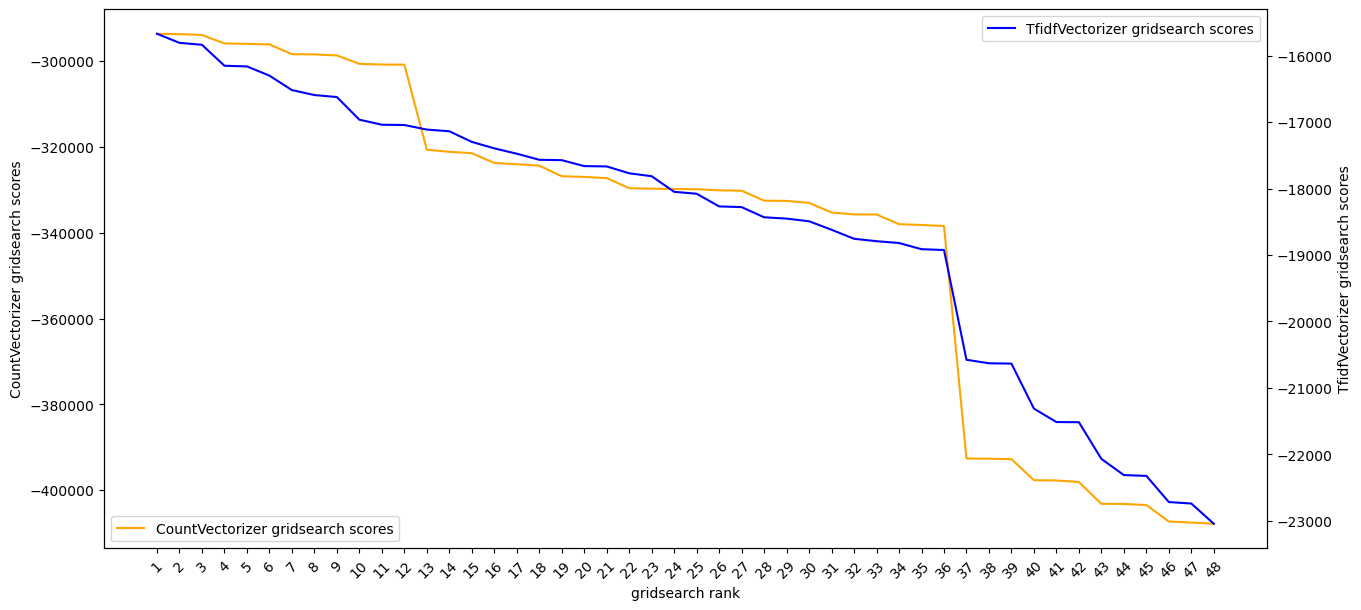

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,7))

tick_labels = [str(i) for i in range(1, 49)]
ax1.set_xticks(ticks = np.arange(1, 49), labels = tick_labels, rotation=45, ha='center')
ax1.set_xlabel('gridsearch rank')
ax1.set_ylabel('CountVectorizer gridsearch scores')
ax1.plot(gs_cv_results.rank_test_score, gs_cv_results.mean_test_score, color = "orange", label = 'CountVectorizer gridsearch scores')
ax1.legend(loc = 'lower left')

# Adding Twin Axes
ax2 = ax1.twinx()
ax2.set_ylabel('TfidfVectorizer gridsearch scores')
ax2.plot(gs_tf_results.rank_test_score, gs_tf_results.mean_test_score, color = "blue", label = 'TfidfVectorizer gridsearch scores')
ax2.legend(loc = 'upper right')

In [ ]:
_ = pd.DataFrame(gs_tf.best_estimator_['lda'].components_.T.round(3), index = gs_tf.best_estimator_['v'].get_feature_names_out(),
                 columns = ["Topic2", "Topic1"])
_.sort_values("Topic1", ascending = False).head(20)
_.sort_values("Topic2", ascending = False).head(20)

In [ ]:
words_by_topic = pd.DataFrame({"Topic1_word" : _.sort_values("Topic1", ascending = False).head(25).index,
                               "Topic1_word_contribution_in_Topic1" : _.sort_values("Topic1", ascending = False).head(25)["Topic1"].values,
                               "Topic1_word_contribution_in_Topic2" : _.sort_values("Topic1", ascending = False).head(25)["Topic2"].values,
                               "Topic2_word" : _.sort_values("Topic2", ascending = False).head(25).index,
                               "Topic2_word_contribution_in_Topic1" : _.sort_values("Topic2", ascending = False).head(25)["Topic1"].values,
                               "Topic2_word_contribution_in_Topic2" : _.sort_values("Topic2", ascending = False).head(25)["Topic2"].values,
                              })

words_by_topic.head()
words_by_topic.to_csv("words_by_topic.csv")

,Unnamed: 0,unnamed,Topic2_word,Topic2_word_contribution_in_Topic2,Topic2_word_contribution_in_Topic1,Topic1_word,Topic1_word_contribution_in_Topic2,Topic1_word_contribution_in_Topic1
0,0,0,oil,17.446,1.378,country,0.533,52.725
1,1,1,spill,10.032,0.606,project,0.545,49.841
2,2,2,refugee,9.036,6.539,support,0.576,38.388
3,3,3,camp,5.756,3.261,community,0.564,38.285
4,4,4,vessel,4.717,0.636,people,0.554,37.791
5,5,5,equatorial,4.334,0.590,water,0.594,35.092
6,6,6,tanker,3.586,0.593,impact,0.704,33.625
7,7,7,southern,3.311,5.996,development,0.526,31.425
8,8,8,condition,3.219,9.919,year,0.561,30.797
9,9,9,northern,3.093,4.046,adaptation,0.522,29.158


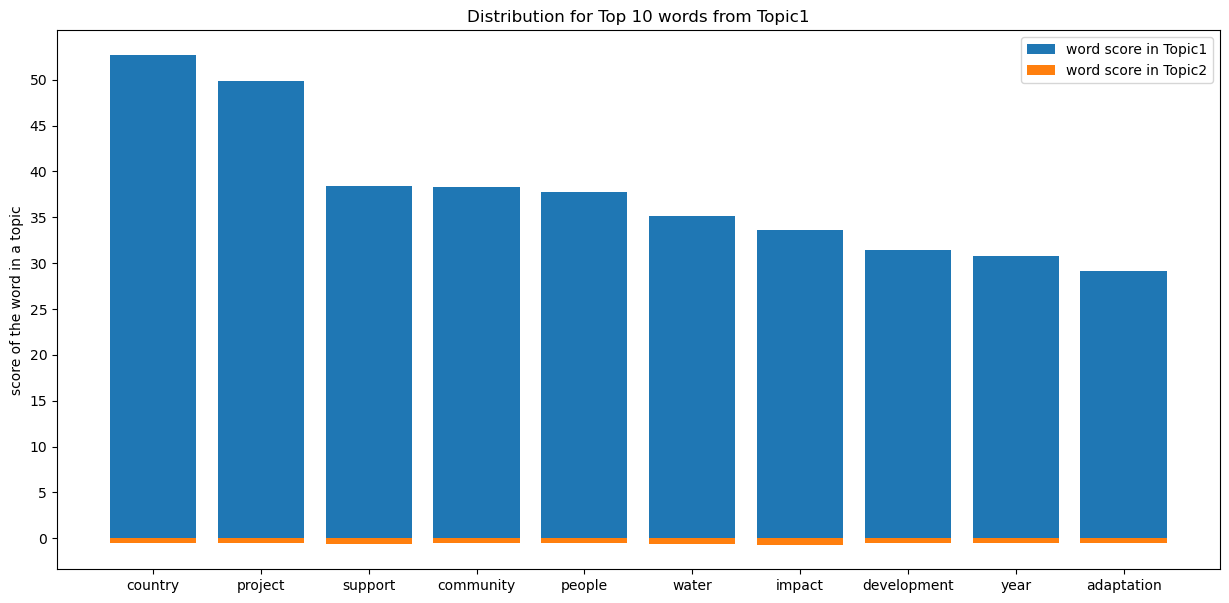

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,7))

ax1.set_title("Distribution for Top 10 words from Topic1")
ax1.set_yticks(ticks = np.arange(-5, 51,5))
ax1.set_ylabel('score of the word in a topic')
ax1.bar(words_by_topic.Topic1_word.head(10), words_by_topic.Topic1_word_contribution_in_Topic1.head(10), label = "word score in Topic1")
ax1.bar(words_by_topic.Topic1_word.head(10), words_by_topic.Topic1_word_contribution_in_Topic2.head(10)*-1, label = "word score in Topic2")
ax1.legend(loc = 'upper right')

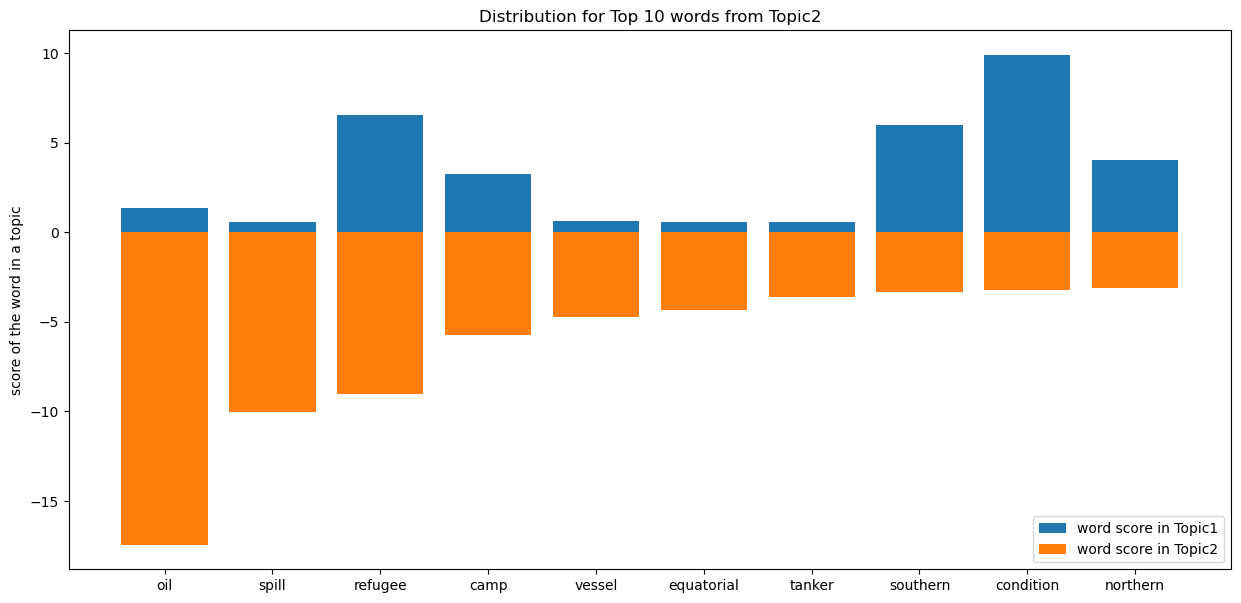

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,7))

ax1.set_title("Distribution for Top 10 words from Topic2")
ax1.set_yticks(ticks = np.arange(-55, 11, 5))
ax1.set_ylabel('score of the word in a topic')
ax1.bar(words_by_topic.Topic2_word.head(10), words_by_topic.Topic2_word_contribution_in_Topic1.head(10), label = "word score in Topic1")
ax1.bar(words_by_topic.Topic2_word.head(10), words_by_topic.Topic2_word_contribution_in_Topic2.head(10)*-1, label = "word score in Topic2")
ax1.legend(loc = 'lower right')